In [3]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Load the dataset
df = pd.read_csv('BBM411-AIN411_Assignment2_Q3_TrainingDataset.tsv', delimiter='\t', header=None)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)
df.head()

,Entry,Entry Name,Sequence,Helix,Beta strand,Turn
1,A0AV96,RBM47_HUMAN,MTAEDSTAAMSSDSAAGSSAKVPEGVAGAPNEAALLALMERTGYSM...,HELIX 164..174; HELIX 204..211;,STRAND 150..156; STRAND 178..182; STRAND 185.....,TURN 189..193; TURN 212..216; TURN 237..239;
2,A0AVT1,UBA6_HUMAN,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,HELIX 45..51; HELIX 53..59; HELIX 71..83; HELI...,STRAND 42..44; STRAND 63..67; STRAND 86..91; S...,TURN 483..485; TURN 506..508; TURN 550..552; T...
3,A0FGR8,ESYT2_HUMAN,MTANRDAALSSHRHPGCAQRPRTPTFASSSQRRSAFGFDDGNFPGL...,HELIX 196..219; HELIX 221..226; HELIX 230..232...,STRAND 235..241; STRAND 248..255; STRAND 264.....,TURN 283..286; TURN 341..345; TURN 405..407; T...
4,A0JLT2,MED19_HUMAN,MENFTALFGAQADPPPPPTALGFGPGKPPPPPPPPAGGGPGTAPPP...,HELIX 83..86; HELIX 90..96; HELIX 112..116; HE...,STRAND 79..81;,TURN 117..119;
5,A1L3X0,ELOV7_HUMAN,MAFSDLTSRTVHLYDNWIKDADPRVEDWLLMSSPLPQTILLGFYVY...,HELIX 17..20; HELIX 23..25; HELIX 35..49; HELI...,STRAND 97..99;,TURN 89..94;


In [5]:
def parse_structure(structure_str, length):
    structure = ['U'] * length  # Initialize all as 'Unknown'
    if pd.isna(structure_str):
        return structure
    for feature in structure_str.split(';'):
        if feature:
            type_, range_str = feature.strip().split(' ')
            start, end = map(int, range_str.split('..'))
            for i in range(start - 1, end):  # Convert to 0-based index
                if type_ == 'HELIX':
                    structure[i] = 'H'
                elif type_ == 'STRAND':
                    structure[i] = 'E'
                elif type_ == 'TURN':
                    structure[i] = 'T'
    return structure

# Correct the column names based on your DataFrame's actual columns
df['helix_parsed'] = df.apply(lambda x: parse_structure(x['Helix'], len(x['Sequence'])), axis=1)
df['strand_parsed'] = df.apply(lambda x: parse_structure(x['Beta strand'], len(x['Sequence'])), axis=1)
df['turn_parsed'] = df.apply(lambda x: parse_structure(x['Turn'], len(x['Sequence'])), axis=1)

# Combine the parsed structures
df['structure'] = df.apply(lambda x: ''.join(x['helix_parsed'][i] if x['helix_parsed'][i] != 'U' else
                                             x['strand_parsed'][i] if x['strand_parsed'][i] != 'U' else
                                             x['turn_parsed'][i] if x['turn_parsed'][i] != 'U' else 'U'
                                             for i in range(len(x['Sequence']))), axis=1)

sequences = df['Sequence'].tolist()
structures = df['structure'].tolist()

print(sequences[0])
print(structures[0])

MTAEDSTAAMSSDSAAGSSAKVPEGVAGAPNEAALLALMERTGYSMVQENGQRKYGGPPPGWEGPHPQRGCEVFVGKIPRDVYEDELVPVFEAVGRIYELRLMMDFDGKNRGYAFVMYCHKHEAKRAVRELNNYEIRPGRLLGVCCSVDNCRLFIGGIPKMKKREEILEEIAKVTEGVLDVIVYASAADKMKNRGFAFVEYESHRAAAMARRKLMPGRIQLWGHQIAVDWAEPEIDVDEDVMETVKILYVRNLMIETTEDTIKKSFGQFNPGCVERVKKIRDYAFVHFTSREDAVHAMNNLNGTELEGSCLEVTLAKPVDKEQYSRYQKAARGGGAAEAAQQPSYVYSCDPYTLAYYGYPYNALIGPNRDYFVKAGSIRGRGRGAAGNRAPGPRGSYLGGYSAGRGIYSRYHEGKGKQQEKGYELVPNLEIPTVNPVAIKPGTVAIPAIGAQYSMFPAAPAPKMIEDGKIHTVEHMISPIAVQPDPASAAAAAAAAAAAAAAVIPTVSTPPPFQGRPITPVYTVAPNVQRIPTAGIYGASYVPFAAPATATIATLQKNAAAAAAMYGGYAGYIPQAFPAAAIQVPIPDVYQTY
UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUEEEEEEEUUUUUUUHHHHHHHHHHHUUUEEEEEUUEEEUTTTTTUUEEEEEEEEHHHHHHHHTTTTTUUUUUUUUUUEEEEEUUUUUTTTUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUU

In [6]:
class ProteinStructureHMM:
    def __init__(self):
        self.amino_acid_letters = []
        self.sequence_letters = []
        self.transitionMatrix = None
        self.emissionMatrix = None
        self.initialMtateMatrix = None
    
    def prepare_data(self, sequences, structures):
        self.sequences = sequences
        self.structures = structures
        self.amino_acid_letters = sorted(list({i for aa_seq in sequences for i in set(aa_seq)}))
        self.sequence_letters = sorted(list({i for ss_seq in structures for i in set(ss_seq)}))

        # Initialize matrices
        self.emissionMatrix = np.zeros((len(self.sequence_letters), len(self.amino_acid_letters)))
        self.initialMtateMatrix = np.zeros((len(self.sequence_letters), 1))
        self.transitionMatrix = np.zeros((len(self.sequence_letters), len(self.sequence_letters)))

        self.train_transition_matrix()
        self.train_emission_matrix()
        self.train_initial_state_matrix()    

    def train_transition_matrix(self):
        for sample in self.structures:
            for i in range(len(sample) - 1):
                self.transitionMatrix[self.sequence_letters.index(sample[i])][self.sequence_letters.index(sample[i + 1])] += 1

        self.transitionMatrix /= np.sum(self.transitionMatrix, axis=1)[:, None]
        self.transitionMatrix = np.log2(self.transitionMatrix)
    
    def train_emission_matrix(self):
        for sample_i in range(len(self.structures)):
            ss = self.structures[sample_i]
            aa = self.sequences[sample_i]
            for i in range(len(ss)):
                self.emissionMatrix[self.sequence_letters.index(ss[i])][self.amino_acid_letters.index(aa[i])] += 1

        self.emissionMatrix = (self.emissionMatrix + 1) / (np.sum(self.emissionMatrix, axis=1) + 20)[:, None]
        self.emissionMatrix = np.log2(self.emissionMatrix)

    def train_initial_state_matrix(self):
        initialLetters = [ss_seq[0] for ss_seq in self.structures]
        unique, counts = np.unique(np.array(initialLetters), return_counts=True)
        probs = counts / counts.sum()
        for letter, prob in zip(unique, probs):
            self.initialMtateMatrix[self.sequence_letters.index(letter)] = prob

        self.initialMtateMatrix = np.log2(self.initialMtateMatrix)
    
    def viterbi(self, test_seq):
        # Initialize tables
        partial_scores_table = np.zeros((len(self.sequence_letters), len(test_seq)))
        backtrace_table = np.zeros((len(self.sequence_letters), len(test_seq)), dtype='object')

        # Initialization step
        for state in self.sequence_letters:
            state_index = self.sequence_letters.index(state)
            aa_index = self.amino_acid_letters.index(test_seq[0])
            isprobability = self.initialMtateMatrix[state_index][0]
            eprobability = self.emissionMatrix[state_index][aa_index]
            partial_scores_table[state_index][0] = isprobability + eprobability

        # Recursion step
        for i in range(1, len(test_seq)):
            for state in self.sequence_letters:
                prob, backtrace_from = self._viterbi_step(state, test_seq, i, partial_scores_table)
                partial_scores_table[self.sequence_letters.index(state)][i] = prob
                backtrace_table[self.sequence_letters.index(state)][i] = backtrace_from

        # Termination step
        lastColMaxİndex = np.argmax(partial_scores_table[:, -1])
        pathProbability = partial_scores_table[lastColMaxİndex][-1]

        hidden_seq = self.sequence_letters[lastColMaxİndex]
        for i in range(backtrace_table.shape[1] - 1, 0, -1):
            letter = backtrace_table[lastColMaxİndex][i]
            hidden_seq += letter
            lastColMaxİndex = self.sequence_letters.index(letter)


        predictedSsSequence = hidden_seq[::-1]
        return predictedSsSequence, pathProbability

    def format_output(self, uniprot_id, protein_name, sequence, predicted_ss_sequence, path_prob_log):
        helix_indices = self.find_ss_indices(predicted_ss_sequence, 'H')
        strand_indices = self.find_ss_indices(predicted_ss_sequence, 'E')
        turn_indices = self.find_ss_indices(predicted_ss_sequence, 'T')

        formatted_output = f"{uniprot_id}\t{protein_name}\t{sequence}\t{helix_indices}\t{strand_indices}\t{turn_indices};\tPath probability: 2^{path_prob_log};"
        return formatted_output

    def find_ss_indices(self, ss_sequence, ss_type):
        regions = []
        in_region = False
        start = end = None

        for i, ss in enumerate(ss_sequence):
            if ss == ss_type and not in_region:
                start = i + 1  # 1-based index
                in_region = True
            elif ss != ss_type and in_region:
                end = i  # end is exclusive, so no +1
                regions.append(f"{ss_type.upper()} {start}..{end};")
                in_region = False

        if in_region:
            end = len(ss_sequence)
            regions.append(f"{ss_type.upper()} {start}..{end};")

        return ' '.join(regions)

    def _viterbi_step(self, state, test_seq, i, partial_scores_table):
        eprobability = self.emissionMatrix[self.sequence_letters.index(state)][self.amino_acid_letters.index(test_seq[i])]
        maxTermList = [partial_scores_table[k][i - 1] + self.transitionMatrix[k][self.sequence_letters.index(state)] for k in range(len(self.sequence_letters))]

        prob = eprobability + max(maxTermList)
        backtrace_from = np.argmax(np.array(maxTermList))

        return prob, self.sequence_letters[backtrace_from]
 
    def calculate_confusion_matrix_row(self, true_element, true_sequence, pred_sequence):
        count_pred_as = {'H': 0, 'E': 0, 'T': 0, 'U': 0}
        for i in range(len(true_sequence)):
            if (true_sequence[i] == '_'):
                true_sequence[i] = 'U'
            if true_sequence[i] == true_element:
                count_pred_as[pred_sequence[i]] += 1
        return count_pred_as

    def calculate_performance_metrics(self, true_sequence, pred_sequence):
        metrics = {}
        elements = ['H', 'E', 'T', 'U']
        confusion_matrix = {el: self.calculate_confusion_matrix_row(el, true_sequence, pred_sequence) for el in elements}

        # Calculate TP, TN, FP, FN, Precision, Recall, F1 Score, and Accuracy for each element
        for el in elements:
            tp = confusion_matrix[el][el]
            tn = sum(confusion_matrix[other_el][other_el] for other_el in elements if other_el != el)
            fp = sum(confusion_matrix[other_el][el] for other_el in elements if other_el != el)
            fn = sum(confusion_matrix[el][other_el] for other_el in elements if other_el != el)

            prec = self.safe_divide(tp, tp + fp)
            recall = self.safe_divide(tp, tp + fn)
            f1 = self.safe_divide(2 * prec * recall, prec + recall)
            acc = self.safe_divide(tp + tn, tp + tn + fp + fn)

            metrics[el] = {'Precision': prec, 'Recall': recall, 'F1 Score': f1, 'Accuracy': acc}

        return metrics, confusion_matrix

    @staticmethod
    def safe_divide(numerator, denominator):
        return numerator / denominator if denominator != 0 else 0

    def display_metrics_and_confusion_matrix(self, true_sequence, pred_sequence):
        # Calculate confusion matrix and metrics
        metrics, confusion_matrix = self.calculate_performance_metrics(true_sequence, pred_sequence)

        # Display the performance metrics
        print("\n\tPrec\tRecall\tF1\tAcc")
        for el in ['H', 'E', 'T', 'U']:
            metrics_str = "\t".join(f"{metrics[el][metric]:.4f}" for metric in ['Precision', 'Recall', 'F1 Score', 'Accuracy'])
            print(f"{el}\t{metrics_str}")

        # Calculate and print Overall Accuracy
        overall_accuracy = sum(confusion_matrix[el][el] for el in ['H', 'E', 'T', 'U']) / sum(sum(confusion_matrix[el].values()) for el in ['H', 'E', 'T', 'U'])
        print('\nOverall Accuracy:', round(overall_accuracy, 4))

        # Display the Confusion Matrix
        self.plot_confusion_matrix(confusion_matrix)

    def plot_confusion_matrix(self, confusion_matrix):
        cm_array = [[confusion_matrix[true_el][pred_el] for pred_el in ['H', 'E', 'T', 'U']] for true_el in ['H', 'E', 'T', 'U']]
        df_cm = pd.DataFrame(cm_array, index=['H', 'E', 'T', 'U'], columns=['H', 'E', 'T', 'U'])
        sn.heatmap(df_cm, annot=True, fmt="d")
        plt.title("Confusion Matrix\n")
        plt.xlabel('Predicted')
        plt.ylabel('Ground Truth')
        plt.show()

    def analyze_sequence(self, test_sequence, true_sequence, uniprot_id, protein_name):
        pred_ss_sequence, path_prob_log = self.viterbi(test_sequence)
        self.display_metrics_and_confusion_matrix(true_sequence, pred_ss_sequence)
        return self.format_output(uniprot_id, protein_name, test_sequence, pred_ss_sequence, path_prob_log)



In [7]:
def get_true_sequence(data, sequence_length):
    sequence = ['U'] * sequence_length

    for structure, start, end in data:
        structure_letter = 'H' if structure == "Helix" else 'E' if structure == "Beta strand" else 'T' if structure == "Turn" else 'U'
        for i in range(start, end + 1):
            sequence[i] = structure_letter

    return ''.join(sequence)

uniprot_id = "O00762"
protein_name = "UBE2C_HUMAN"
sequence_data = "MASQNRDPAATSVAAARKGAEPSGGAARGPVGKRLQQELMTLMMSGDKGISAFPESDNLFKWVGTIHGAAGTVYEDLRYKLSLEFPSGYPYNAPTVKFLTPCYHPNVDTQGNICLDILKEKWSALYDVRTILLSIQSLLGEPNIDSPLNTHAAELWKNPTAFKKYLQETYSKQVTSQEP"

sse_data = [
    ("Helix", 30, 45),
    ("Beta strand", 50, 54),
    ("Beta strand", 61, 68),
    ("Beta strand", 78, 84),
    ("Turn", 87, 91),
    ("Beta strand", 95, 100),
    ("Beta strand", 111, 113),
    ("Helix", 116, 118),
    ("Turn", 119, 121),
    ("Helix", 128, 140),
    ("Helix", 150, 155),
    ("Helix", 159, 172)
]

true_sequence = get_true_sequence(sse_data, len(sequence_data))
print(true_sequence)

UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUHHHHHHHHHHHHHHHHUUUUEEEEEUUUUUUEEEEEEEEUUUUUUUUUEEEEEEEUUTTTTTUUUEEEEEEUUUUUUUUUUEEEUUHHHTTTUUUUUUHHHHHHHHHHHHHUUUUUUUUUHHHHHHUUUHHHHHHHHHHHHHHUUUUUU



	Prec	Recall	F1	Acc
H	0.0000	0.0000	0.0000	0.6338
E	0.0000	0.0000	0.0000	0.7563
T	0.0000	0.0000	0.0000	0.9184
U	0.5028	1.0000	0.6691	0.5028

Overall Accuracy: 0.5028


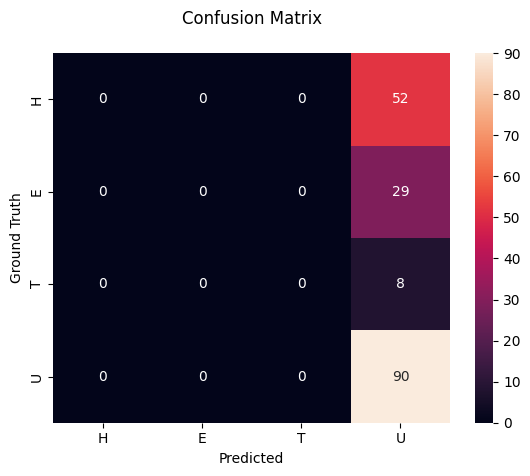

O00762	UBE2C_HUMAN	MASQNRDPAATSVAAARKGAEPSGGAARGPVGKRLQQELMTLMMSGDKGISAFPESDNLFKWVGTIHGAAGTVYEDLRYKLSLEFPSGYPYNAPTVKFLTPCYHPNVDTQGNICLDILKEKWSALYDVRTILLSIQSLLGEPNIDSPLNTHAAELWKNPTAFKKYLQETYSKQVTSQEP			;	Path probability: 2^-765.2537477371969;


In [8]:
model = ProteinStructureHMM()
model.prepare_data(sequences, structures)
formatted_output = model.analyze_sequence(sequence_data, true_sequence, uniprot_id, protein_name)
print(formatted_output)